In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

DATASET_PATH = "Tsunami.csv"
RANDOM_STATE = 42
BATCH_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 1e-3

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

ModuleNotFoundError: No module named 'torch'

In [ ]:
target = "Number of Runups"
base_columns = [
    "Tsunami Event Validity",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    target,
 ]

tsunami_df = (
    pd.read_csv(DATASET_PATH, usecols=base_columns)
    .dropna(subset=base_columns)
    .reset_index(drop=True)
 )

print("Preprocessed DataFrame shape:", tsunami_df.shape)

Preprocessed DataFrame shape: (1691, 5)


In [ ]:
print("Number of Runups statistics:")
print(tsunami_df[target].describe())
print(f"\nUnique values: {tsunami_df[target].nunique()}")
print(
    f"Data is right-skewed: median={tsunami_df[target].median():.0f}, max={tsunami_df[target].max():.0f}"
)

correlations = tsunami_df.corr(numeric_only=True)[target].drop(target)
print("\nCorrelation with Number of Runups:")
for feature, corr in correlations.sort_values(key=abs, ascending=False).items():
    print(f"{feature:25s}: {corr:6.3f}")

Number of Runups statistics:
count    1691.000000
mean       17.991721
std       175.902663
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      6421.000000
Name: Number of Runups, dtype: float64

Unique values: 115
Data is right-skewed: median=2, max=6421

Correlation with Number of Runups:
Earthquake Magnitude     :  0.164
Tsunami Event Validity   :  0.073
Longitude                :  0.008
Latitude                 :  0.005


In [ ]:
tsunami_df = tsunami_df.assign(
    Eq_Magnitude_Squared=lambda df: df["Earthquake Magnitude"] ** 2,
    Coastal_Distance=lambda df: np.hypot(df["Latitude"], df["Longitude"]),
    Is_Pacific_Ring=lambda df: ((
        df["Latitude"].between(10, 60)
        & df["Longitude"].between(120, 180)
    )
    | (
        df["Latitude"].between(-60, 10)
        & df["Longitude"].between(-180, -100)
    )).astype(int),
)

feature_columns = [
    "Tsunami Event Validity",
    "Earthquake Magnitude",
    "Eq_Magnitude_Squared",
    "Latitude",
    "Longitude",
    "Coastal_Distance",
    "Is_Pacific_Ring",
]

X = tsunami_df[feature_columns].to_numpy(dtype=np.float32)
y = np.log1p(tsunami_df[target].to_numpy(dtype=np.float32))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

train_dataset = TensorDataset(
    torch.from_numpy(X_train_scaled),
    torch.from_numpy(y_train.reshape(-1, 1)),
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_scaled),
    torch.from_numpy(y_test.reshape(-1, 1)),
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Using {len(feature_columns)} engineered spatial and magnitude features")

Training set: (1352, 7)
Test set: (339, 7)
Using engineered spatial and magnitude features


In [ ]:
class TsunamiRegressor(nn.Module):
    """Lightweight feed-forward network for log-transformed runup counts."""
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

input_dim = X_train_scaled.shape[1]
model = TsunamiRegressor(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

train_history = []
val_history = []

print(model)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Training RF with near-default hyperparameters...
Training GB with near-default hyperparameters...
Training XGB with near-default hyperparameters...
Training XGB with near-default hyperparameters...


In [ ]:
best_state = None
best_val = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        preds = model(features)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)
            preds = model(features)
            loss = criterion(preds, targets)
            val_loss += loss.item() * features.size(0)
            val_samples += features.size(0)

    epoch_val_loss = val_loss / val_samples
    train_history.append(epoch_train_loss)
    val_history.append(epoch_val_loss)

    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(
            f"Epoch {epoch + 1:03d} | Train MSE: {epoch_train_loss:.4f} | Val MSE: {epoch_val_loss:.4f}"
        )

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Loaded best model with validation MSE={best_val:.4f}")


Ensemble Model Performance (RF + GB + XGB):
  R² Score: 0.3431
  RMSE (log): 0.9659
  MAE (log): 0.6603

Original Scale:
  RMSE: 50.33 runups
  MAE: 12.57 runups

Individual Model Performance (near-default settings):
  RF: R² = 0.3075
  GB: R² = 0.4125
  XGB: R² = 0.1826


Top Features:
                  feature  importance
0  Tsunami Event Validity    0.378116
1    Earthquake Magnitude    0.172654
2                Latitude    0.111463
3    Eq_Magnitude_Squared    0.109989
4               Longitude    0.096947
5        Coastal_Distance    0.096171
6         Is_Pacific_Ring    0.034659


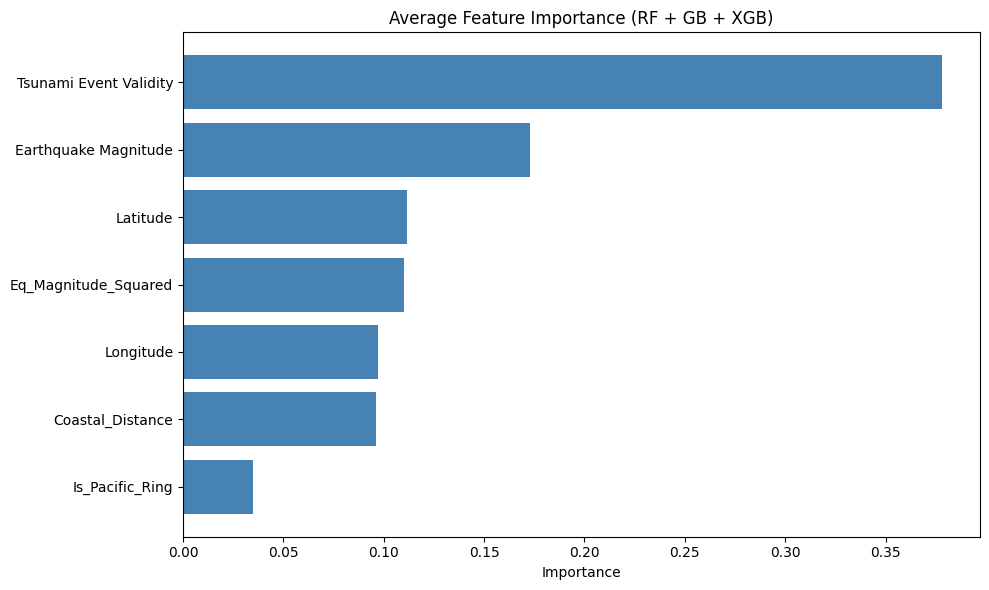

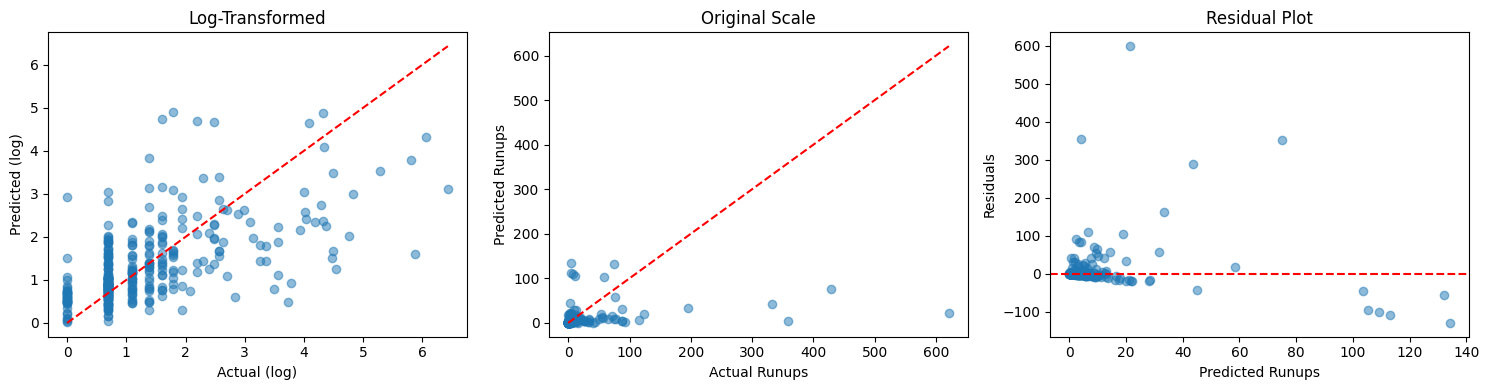


Model Summary:
  Explains 34.3% of variance
  Average error: ±12.6 runups


In [ ]:
model.eval()
with torch.no_grad():
    test_features = torch.from_numpy(X_test_scaled).to(device)
    y_pred_log = model(test_features).cpu().numpy().squeeze()

y_true_log = y_test
y_true = np.expm1(y_true_log)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_true_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("PyTorch Regressor Performance (log target):")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE (log): {rmse_log:.4f}")
print(f"  MAE (log): {mae_log:.4f}")

print("\nOriginal Scale:")
print(f"  RMSE: {rmse:.2f} runups")
print(f"  MAE: {mae:.2f} runups")

epochs = np.arange(1, len(train_history) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, np.sqrt(train_history), label="Train RMSE")
plt.plot(epochs, np.sqrt(val_history), label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training Progress")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(y_true_log, y_pred_log, alpha=0.6)
plt.plot([y_true_log.min(), y_true_log.max()], [y_true_log.min(), y_true_log.max()], "r--")
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
plt.title("Log-Scale Predictions")

plt.subplot(1, 3, 3)
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([0, y_true.max()], [0, y_true.max()], "r--")
plt.xlabel("Actual Runups")
plt.ylabel("Predicted Runups")
plt.title("Original Scale")

plt.tight_layout()
plt.show()

residuals = y_true - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted Runups")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()